# Photometric Stereo

Numpy와 OpenCV-Python을 활용하여 아주 간단한 버전의 Photometric stereo algorithm을 구현해봅시다. (입력 영상 3장)

## Table of Contents

- Load images and normalize intensity values
- Construct I matrix using effective pixels (Exercise 1)
- Photometric stereo (Exercise 2)
- Visualization

## Reference
https://snawarhussain.com/blog/computer%20vision/python/tutorial/photometric-stereo-lambertian-model/

https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html

https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

https://numpy.org/doc/stable/reference/generated/numpy.dot.html#numpy.dot

## 1. Load images and normalize intensity values

OpenCV-Python을 설치하고, 필요한 package들을 import한다.
이때 opencv의 namespace는 cv2인데, cv2를 그대로 사용해도 되고, 아래와 같이 cv로 변환하여 사용해도 된다.
Reference의 코드를 활용할때 주의해야 한다.
Load된 image들의 값은 0에서 255 사이의 uint8 인데, 이를 0에서 1사이의 double 값으로 변환하여 사용한다.
이번 HW에서 사용되는 image들은 greyscale image이다. 

In [1]:
# opencv 설치 (최초 한번만 실행)
!pip install opencv-python

<function matplotlib.pyplot.show(close=None, block=None)>

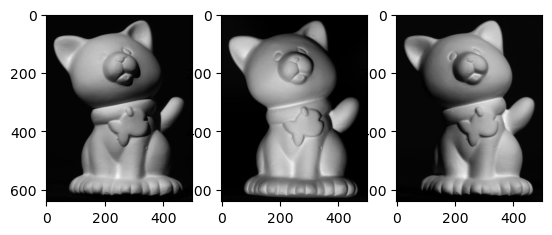

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

filename1 = 'image_01.png'
filename2 = 'image_08.png'
filename3 = 'image_17.png'

img1 = cv.imread(filename1,cv.IMREAD_GRAYSCALE) # grayscale
img2 = cv.imread(filename2,cv.IMREAD_GRAYSCALE)
img3 = cv.imread(filename3,cv.IMREAD_GRAYSCALE)
img1 = img1/255.0  # normalize image intensities to 0~1 value
img2 = img2/255.0
img3 = img3/255.0
plt.subplot(131),plt.imshow(img1, cmap='gray')
plt.subplot(132),plt.imshow(img2, cmap='gray')
plt.subplot(133),plt.imshow(img3, cmap='gray')
plt.show

## 2. Construct I matrix using effective pixels (Exercise 1) [5점]

3장의 image에 있는 intensity값들로 I matrix를 구성하고자 한다. 이때, 고양이의 배경에 해당하는 픽셀들은 photometric stereo를 할 필요가 없으므로, image에서 effective pixel들만 찾아서 mask를 구성한다. mask의 값이 0이면 사용하지 않는 픽셀이고, 1이면 effective pixel이다. 즉, 하나의 image에 $h \times w$ 개의 픽셀이 있지만 이들을 모두 사용하여 I matrix를 구성하지 않고, image1,2,3에서 모두 0보다 큰 값을 가지는 pixel p개만 찾아내서 I matrix를 $(p \times 3)$ shape으로 구성한다.

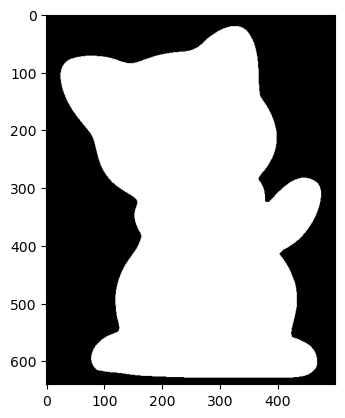

In [3]:
maskidx = (img1 < 0.1) & (img2 < 0.1) & (img3 < 0.1) # boolean
maskidx = ~maskidx
maskimg = np.zeros(img1.shape)
maskimg[maskidx] = 1.0 # effective pixels
plt.imshow(maskimg, cmap='gray')    # plot mask

# EXERCISE 1
# Get the number of effective pixels as p
# Construct px3 matrix of I with image intensities of img1,2,3.
# (~ 5 lines of code)
# p = ...
# I = ...
# I[:,0] = ...
# I[:,1] = ...
# I[:,2] = ...
# YOUR CODE STARTS HERE
p = np.sum(maskidx)
I = np.zeros((p, 3))
I[:,0] = img1[maskidx]
I[:,1] = img2[maskidx]
I[:,2] = img3[maskidx]

# YOUR CODE ENDS HERE

## 3. Photometric Stereo (Exercise 2) [5점]

Image1,2,3를 찍을 때 light direction $L_1, L_2, L_3$ 는 각각 3x1 unit vector이며, 이들을 옆으로 stack하면 3x3 light matrix S가 된다.

$I_{(p \times3)} = N_{(p \times 3)} \cdot S_{(3 \times 3)})$ 

위의 수식에서 I는 관측된 image intensity이고, S는 known light direction이며, N이 우리가 구하고자 하는 surface normal이다. N은 다음과 같이 구할 수 있다.

$N = I \cdot S^{-1}$

이때 구해진 $N$은 아직까지 unit vector가 아니다. 각 pixel의 surface normal vector를 L2 norm으로 나눠주면 비로소 우리가 구하고자 하는 unit vector 형태의 surface normal이 된다. 이때 L2 norm은 각 pixel의 반사율(albedo)라고 볼 수 있다.
Reference의 link를 참조하여 ``np.linalg.inv``,``np.linalg.norm``,``np.dot``을 활용하여 구현하시오.

In [4]:
S =  np.array([[-0.2852235189933585, -0.1564816981353137, 0.3951709389351063],
[0.5446253890200055, -0.0480436063349186, 0.4675701013171391],
[0.7886892479600903, 0.9865116775989140,0.7907073601373815]])

# EXERCISE 2
# Estimate surface normal matrix N by dot product of I and inv(S)
# Then estimate the albedo by computing L2 norm of each surface normal vector
# Modify N to unit vectors by dividing the albedo
# (~ 4 lines of code)
# S_inv = ...
# N = ...
# albedo = ...
# N = ...
# YOUR CODE STARTS HERE
S_inv = np.linalg.inv(S)
N = np.dot(I, S_inv)
albedo = np.linalg.norm(N, axis=1, keepdims=True)
N = N / albedo

# YOUR CODE ENDS HERE

## 4. Visualization

추정된 surface normal은 각 픽셀마다 x,y,z 요소를 가지는 3차원 unit vector이며 각각 -1에서 1 사이의 값이다. 이를 시각화하는 방법 중 하나는 x,y,z를 각각 R,G,B 채널의 0에서 1사이의 값으로 매핑하여 컬러이미지로 만드는 것이다. 

<function matplotlib.pyplot.show(close=None, block=None)>

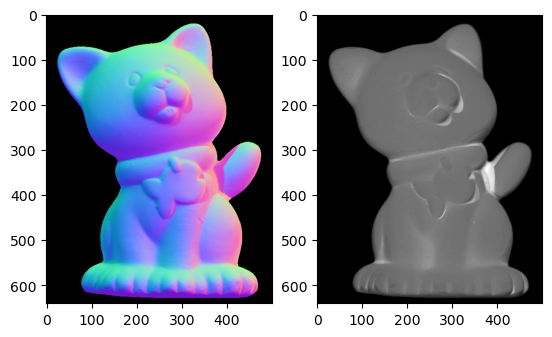

In [5]:
h,w = img1.shape
normal_img = np.zeros((h,w,3))
normal_img_r = np.zeros((h,w))
normal_img_g = np.zeros((h,w))
normal_img_b = np.zeros((h,w))

normal_img_r[maskidx] = (N[:,0]+1)/2.0
normal_img_g[maskidx] = (N[:,1]+1)/2.0
normal_img_b[maskidx] = (N[:,2]+1)/2.0

normal_img[:,:,0] = normal_img_r
normal_img[:,:,1] = normal_img_g
normal_img[:,:,2] = normal_img_b

albedo_img = np.zeros((h,w))
albedo_img[maskidx] = np.squeeze(albedo)

plt.subplot(121),plt.imshow(normal_img)
plt.subplot(122),plt.imshow(albedo_img, cmap='gray')
plt.show

위의 코드를 실행하면 다음과 같은 결과를 얻을 수 있다.
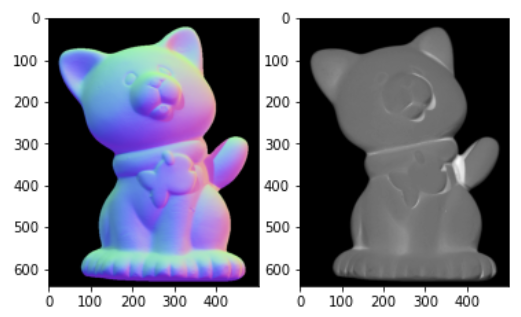